In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap

In [33]:
#reading the csv file
dir  = globals()['_dh'][0].parent
file_path = dir / 'data' / 'cleaned_data.pkl'
df = pd.read_pickle(file_path)
print(df.shape)
df.head(5)

(16680, 16)


,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203


In [34]:
#preparing the data for kmeans
df.drop(['EnrollDate', 'ChurnDate', 'IndustryGroup', 'User_id', 'OrgID'], axis=1, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)

(15797, 11)


In [35]:
# 2. Feature Selection/Engineering
# Identify numerical and categorical features (modify these lists based on your dataset)
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'Churned']
categorical_features = [col for col in df.columns if df[col].dtype == 'object']

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Numerical features: ['F28 Active Rate', 'Avg Lifetime Active', 'F28 Cc Flag', 'eLTV/CAC', 'Enrollment Duration']
Categorical features: ['Industry', 'Acquisition Channel']


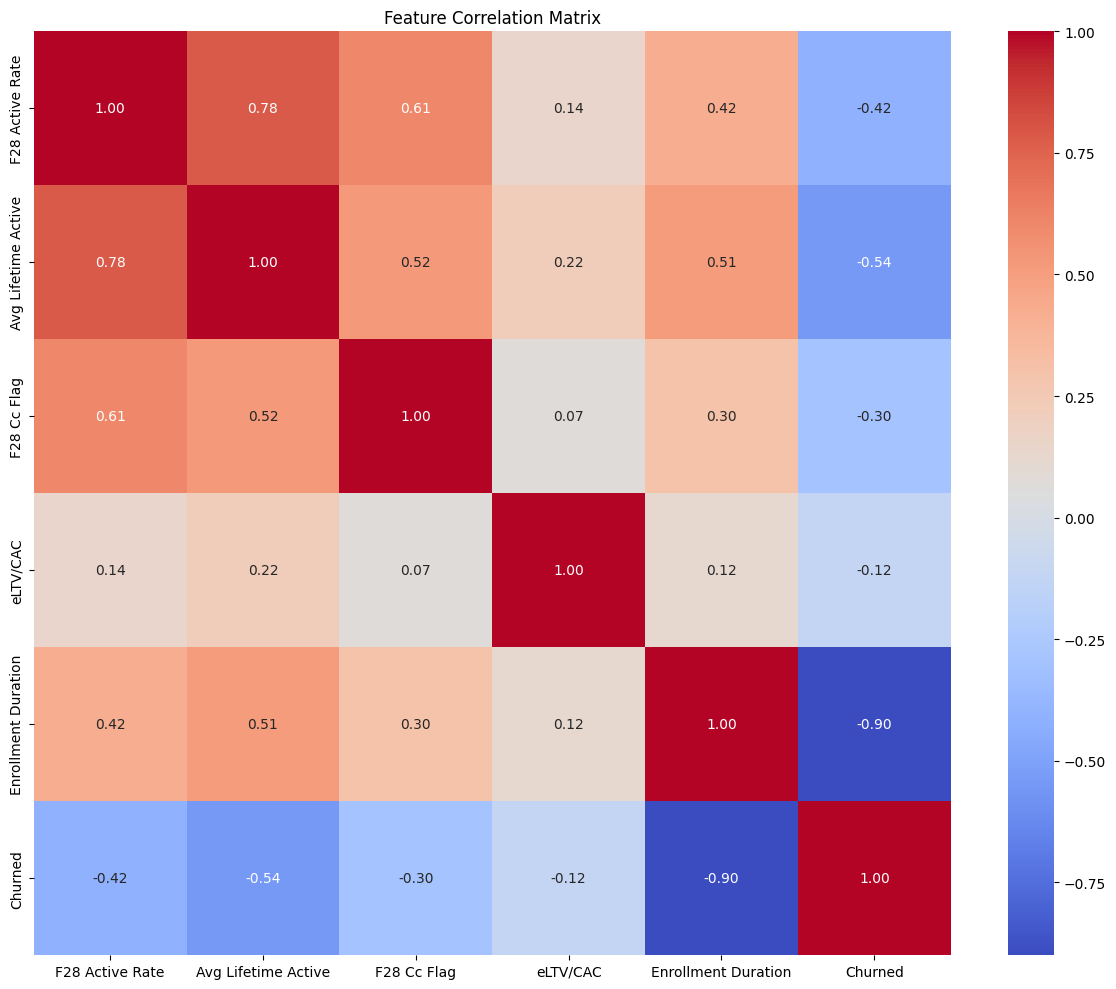

In [36]:
# Feature correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features + ['Churned']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

In [37]:
df.drop(['F28 Active Rate'], axis=1, inplace=True)

In [38]:
# 3. Data Splitting
X = df.drop('Churned', axis=1)
y = df['Churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Training set shape: (12637, 9), Test set shape: (3160, 9)


In [39]:
# 4. Data Preprocessing Pipeline
# Create preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [40]:
# 5. Handle Categorical Features and Preprocessing
# Option 1: One-hot encode categorical features (traditional approach)
# X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

# Option 2: Use XGBoost's native categorical feature support
# Convert category dtype columns to appropriate int codes
for col in categorical_features:
    if col in X_train.columns:
        if X_train[col].dtype.name == 'category':
            # Keep as category type but ensure codes are proper
            X_train[col] = X_train[col].cat.codes
            X_test[col] = X_test[col].cat.codes
        else:
            # Convert string/object columns to category codes
            X_train[col] = pd.Categorical(X_train[col]).codes
            X_test[col] = pd.Categorical(X_test[col]).codes

# For numerical features, just use standard scaling
scaler = StandardScaler()
for col in numerical_features:
    if col in X_train.columns:
        X_train[col] = scaler.fit_transform(X_train[[col]])
        X_test[col] = scaler.transform(X_test[[col]])

# Now our data is ready with encoded categorical features
X_train_preprocessed = X_train
X_test_preprocessed = X_test

In [41]:
# 6. Model Building with XGBoost
# Initial XGBoost model with default parameters
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    enable_categorical= True
)

In [42]:
# 7. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Use a smaller parameter grid for initial testing (uncomment for full grid search)
small_param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5],
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [1]
}

# Comment the next line and uncomment the following line for a full grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=small_param_grid, 
                          cv=StratifiedKFold(5), scoring='roc_auc', verbose=1, n_jobs=-1)
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
#                           cv=StratifiedKFold(5), scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\gfmar\OneDrive\Vagas\HCP\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Best ROC-AUC score: 0.9985



Model Performance Metrics:
Accuracy: 0.9940
Precision: 0.9869
Recall: 0.9984
F1-Score: 0.9926
ROC-AUC: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1882
           1       0.99      1.00      0.99      1278

    accuracy                           0.99      3160
   macro avg       0.99      0.99      0.99      3160
weighted avg       0.99      0.99      0.99      3160



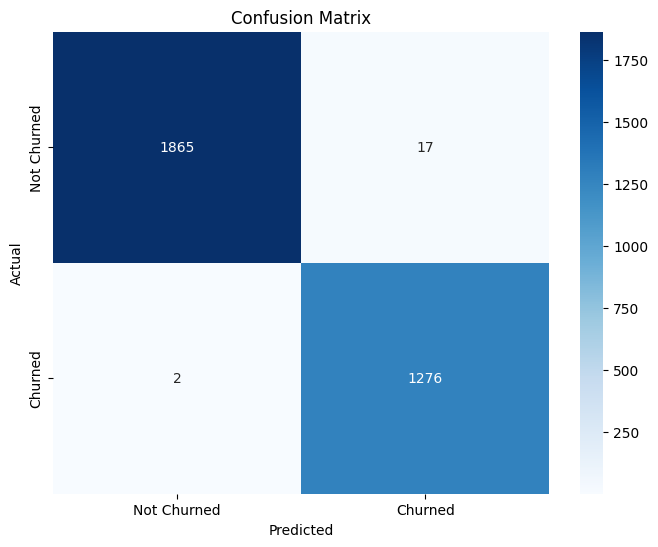

In [43]:
# 8. Model Evaluation
# Predictions on test set
y_pred_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]
y_pred = best_model.predict(X_test_preprocessed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'], 
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

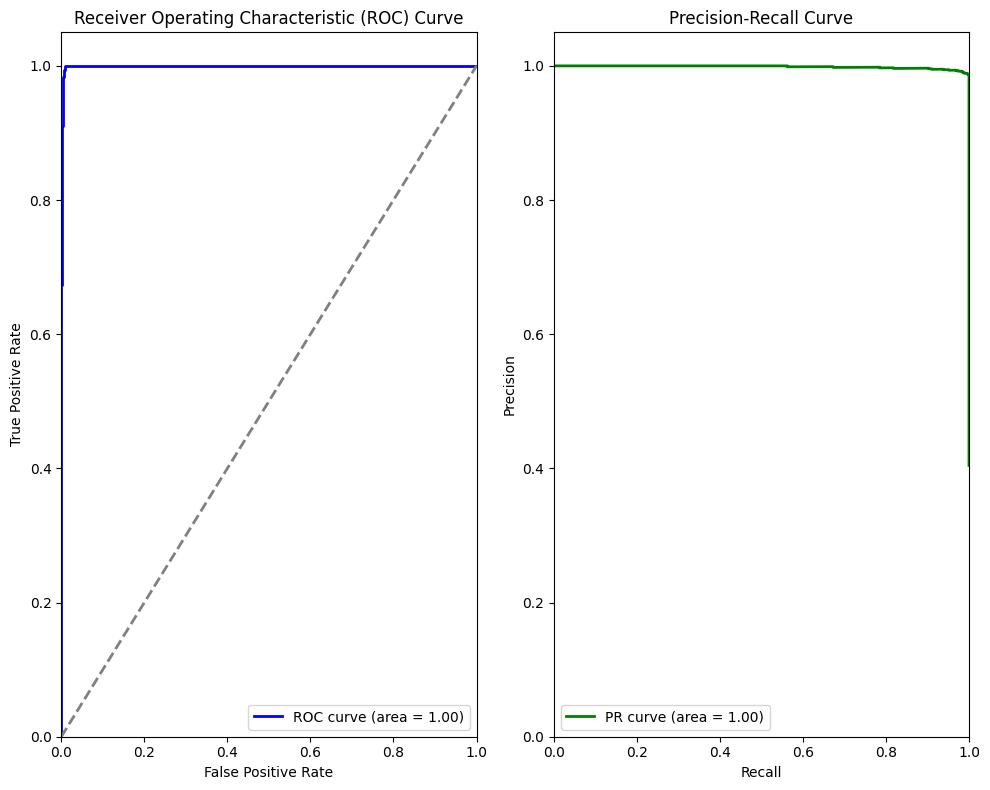

In [44]:
# 9. ROC Curve and Precision-Recall Curve
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig('roc_pr_curves.png')

<Figure size 1200x800 with 0 Axes>

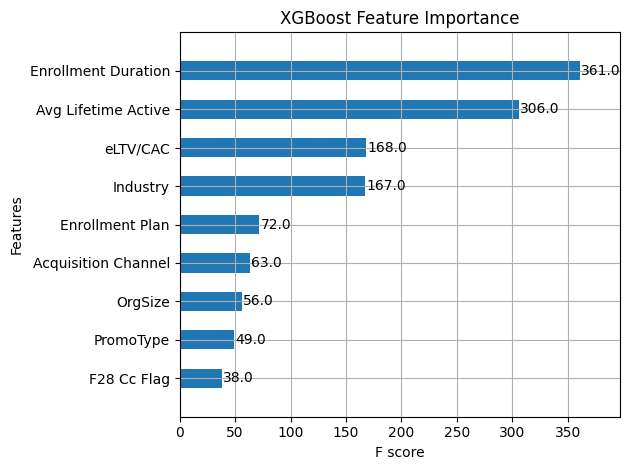

In [45]:
# 10. Feature Importance Analysis
# Since we're using native categorical features without one-hot encoding,
# we can use column names directly
all_feature_names = X_train.columns.tolist()

# Plot XGBoost feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(best_model, max_num_features=20, height=0.5)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance_xgboost.png')


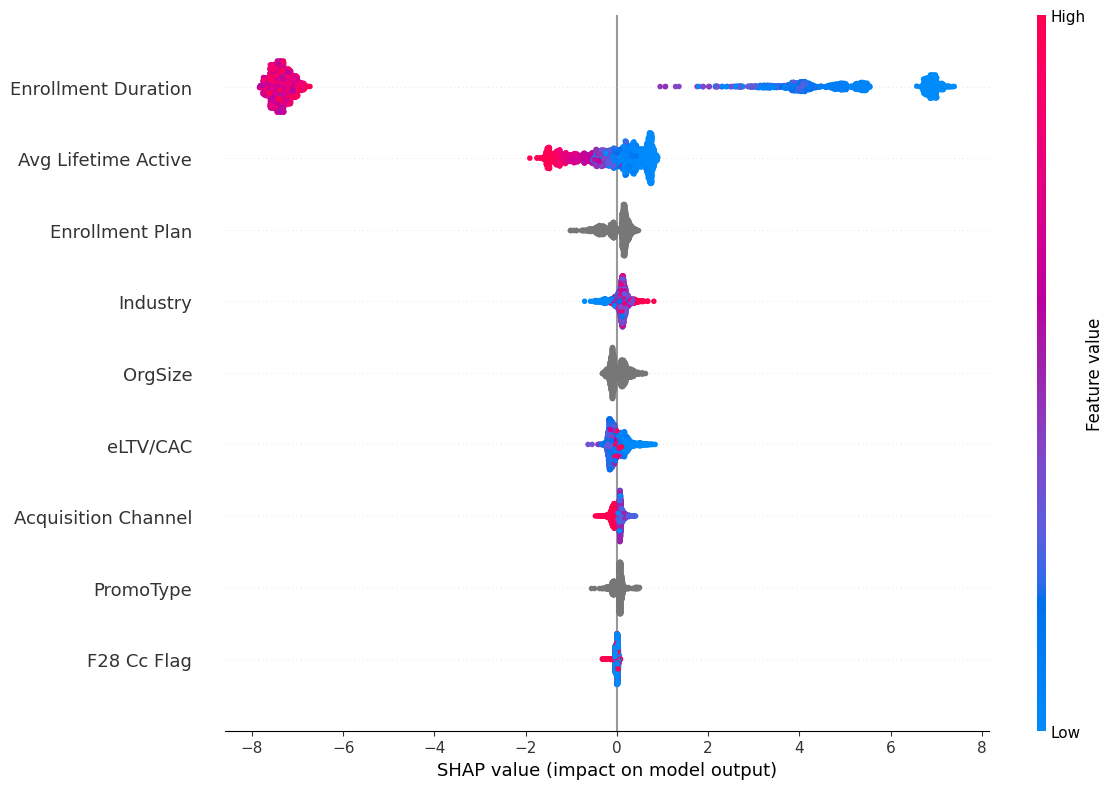

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

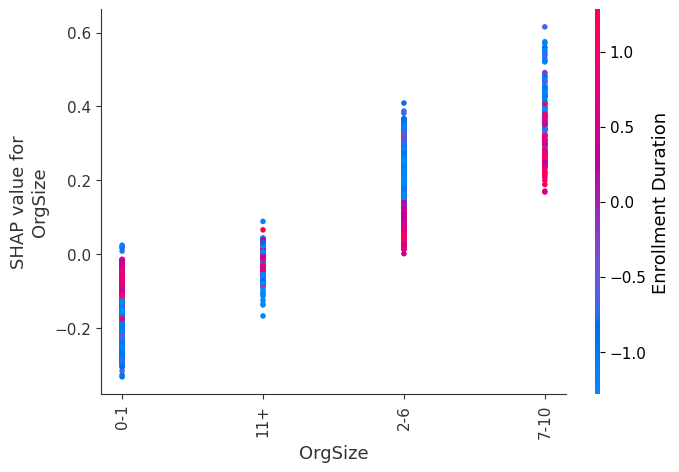

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

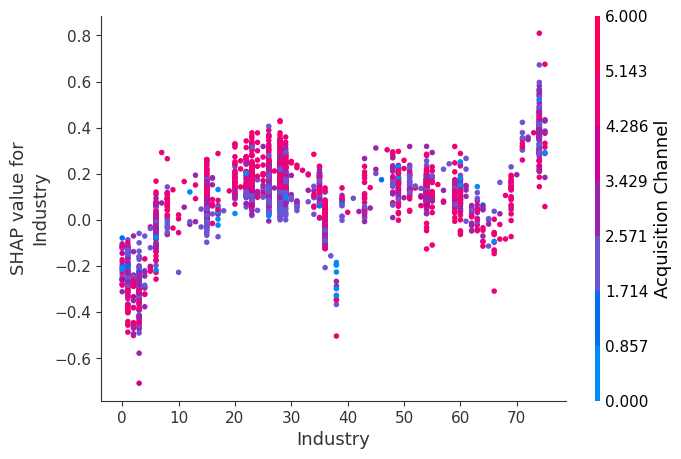

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

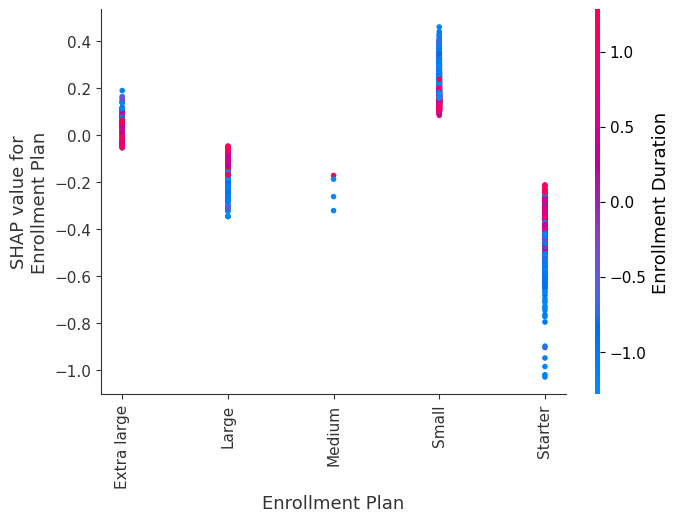

<Figure size 640x480 with 0 Axes>

In [46]:
# 11. SHAP Values for Model Explainability
# Initialize SHAP explainer
try:
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test_preprocessed)
    
    # Summary Plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test_preprocessed, feature_names=all_feature_names, plot_size=(12, 8))
    plt.savefig('shap_summary.png')
    
    # Detailed SHAP plots for top influential features
    for i in range(min(3, len(all_feature_names))):
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(i, shap_values.values, X_test_preprocessed, feature_names=all_feature_names)
        plt.savefig(f'shap_dependence_{i}.png')
except Exception as e:
    print(f"Skipping SHAP analysis due to error: {e}")

In [47]:
# 12. Model Save
best_model.save_model('churn_prediction_model.json')
print("\nModel saved as 'churn_prediction_model.json'")


Model saved as 'churn_prediction_model.json'


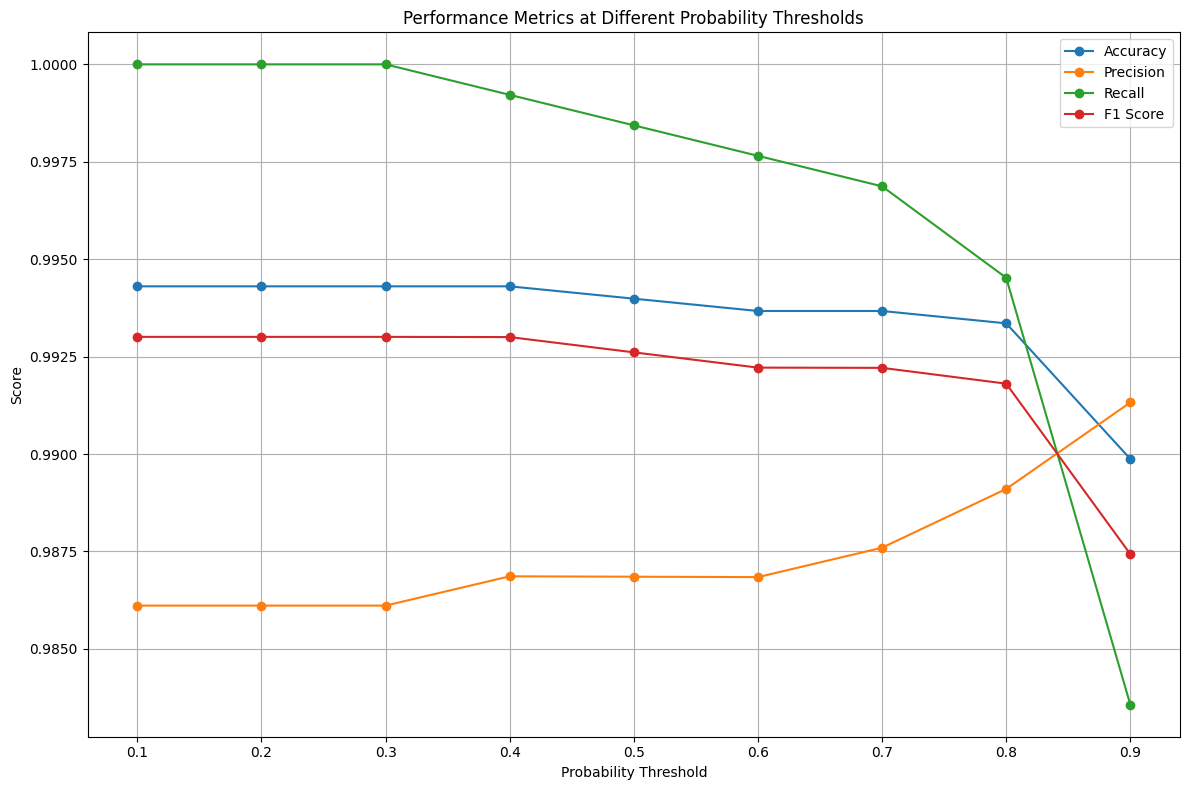

In [48]:
# 13. Churn Probability Threshold Analysis
# Try different thresholds for churn prediction
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_threshold)
    precision = precision_score(y_test, y_pred_threshold, zero_division=0)
    recall = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    
    threshold_metrics.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

threshold_df = pd.DataFrame(threshold_metrics)

plt.figure(figsize=(12, 8))
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'o-', label='Accuracy')
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'o-', label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'o-', label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1_score'], 'o-', label='F1 Score')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Different Probability Thresholds')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('threshold_analysis.png')


Optimal threshold for maximum business impact: 0.10
Expected financial impact at this threshold: $1148400.00


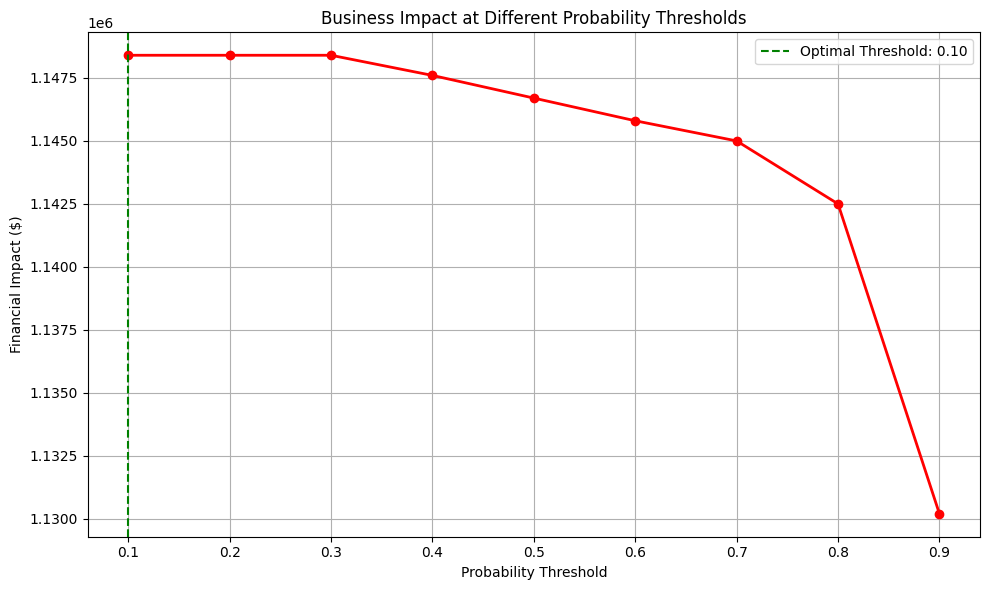

In [49]:
# 14. Business Impact Simulation
# Example: Calculate the potential financial impact of identifying and preventing churn
# Assuming an average customer value of $1000 per year and intervention cost of $100
avg_customer_value = 1000  # Change to your business value
intervention_cost = 100    # Change to your intervention cost

threshold_df['true_positives'] = threshold_df['threshold'].apply(
    lambda t: sum((y_pred_proba >= t) & (y_test == 1))
)
threshold_df['false_positives'] = threshold_df['threshold'].apply(
    lambda t: sum((y_pred_proba >= t) & (y_test == 0))
)
threshold_df['false_negatives'] = threshold_df['threshold'].apply(
    lambda t: sum((y_pred_proba < t) & (y_test == 1))
)

# Calculate financial impact (saved value - intervention costs)
threshold_df['financial_impact'] = (threshold_df['true_positives'] * avg_customer_value) - \
                                  ((threshold_df['true_positives'] + threshold_df['false_positives']) * intervention_cost)

# Find the optimal threshold for business impact
optimal_threshold = threshold_df.loc[threshold_df['financial_impact'].idxmax(), 'threshold']
print(f"\nOptimal threshold for maximum business impact: {optimal_threshold:.2f}")
print(f"Expected financial impact at this threshold: ${threshold_df['financial_impact'].max():.2f}")

plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['financial_impact'], 'ro-', linewidth=2)
plt.axvline(x=optimal_threshold, color='green', linestyle='--', 
            label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Probability Threshold')
plt.ylabel('Financial Impact ($)')
plt.title('Business Impact at Different Probability Thresholds')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('business_impact.png')


Final Model Performance (with optimal threshold):
Accuracy: 0.9943
Precision: 0.9861
Recall: 1.0000
F1-Score: 0.9930

Confusion Matrix (with optimal threshold):
[[1864   18]
 [   0 1278]]

Customer Risk Segment Report:
  risk_segment  count  percentage
0     Low Risk   1864   58.987342
1  Medium Risk      4    0.126582
2    High Risk   1292   40.886076

XGBoost Churn Prediction Model completed successfully!


C:\Users\gfmar\AppData\Local\Temp\ipykernel_18816\2654888911.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_segment_report = X_test_with_proba.groupby('risk_segment').size().reset_index(name='count')
C:\Users\gfmar\AppData\Local\Temp\ipykernel_18816\2654888911.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_segment', y='percentage', data=risk_segment_report, palette='YlOrRd')


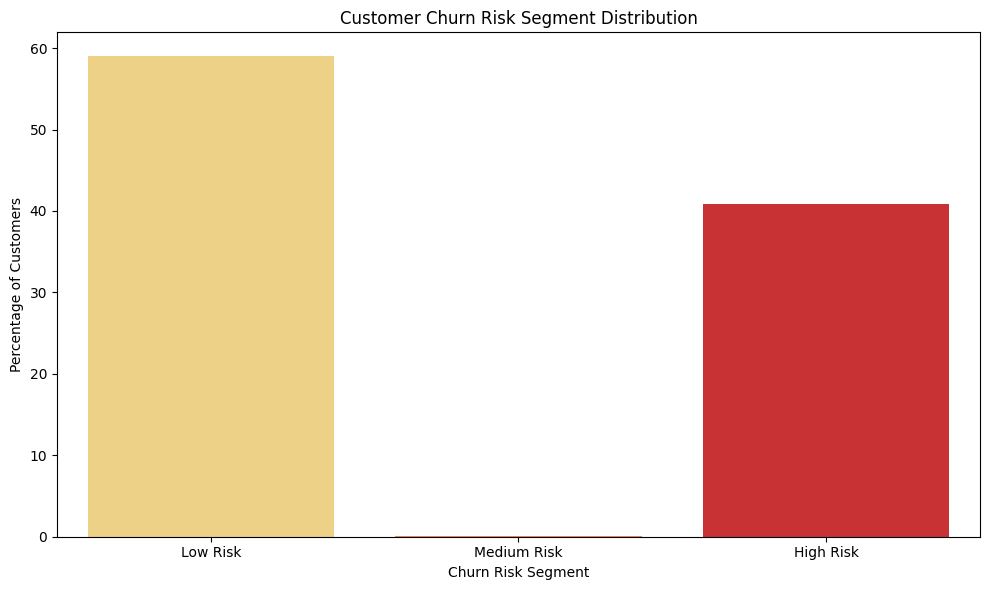

In [50]:
# 15. Final Model Predictions
# Make final predictions using the optimal threshold
final_predictions = (y_pred_proba >= optimal_threshold).astype(int)

print("\nFinal Model Performance (with optimal threshold):")
print(f"Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"Precision: {precision_score(y_test, final_predictions):.4f}")
print(f"Recall: {recall_score(y_test, final_predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, final_predictions):.4f}")

print("\nConfusion Matrix (with optimal threshold):")
print(confusion_matrix(y_test, final_predictions))

# 16. Generate Churn Risk Segment Report
# Divide customers into risk segments
X_test_with_proba = X_test.copy()
X_test_with_proba['churn_probability'] = y_pred_proba

# Define risk segments
X_test_with_proba['risk_segment'] = pd.cut(
    X_test_with_proba['churn_probability'], 
    bins=[0, 0.3, 0.6, 1.0], 
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Generate risk segment report
risk_segment_report = X_test_with_proba.groupby('risk_segment').size().reset_index(name='count')
risk_segment_report['percentage'] = risk_segment_report['count'] / len(X_test_with_proba) * 100

print("\nCustomer Risk Segment Report:")
print(risk_segment_report)

# Plot the risk segment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='risk_segment', y='percentage', data=risk_segment_report, palette='YlOrRd')
plt.xlabel('Churn Risk Segment')
plt.ylabel('Percentage of Customers')
plt.title('Customer Churn Risk Segment Distribution')
plt.tight_layout()
plt.savefig('risk_segments.png')

print("\nXGBoost Churn Prediction Model completed successfully!")